# Model hiper optimization

In [1]:
#imports
import os
from copy import copy
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tpot import TPOTClassifier

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.2 - 060 with zone groups - tpot"

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [3]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [5]:
pd.crosstab(df["total_condicion"], [df["EXISTE_FRAUDE"], df["TIPO_EXPED"]])

EXISTE_FRAUDE   False                                                   True   \
TIPO_EXPED          0      1       2       3      4     5      6      7     0   
total_condicion                                                                 
0.0              4053  61640  417806  368526  10187     0  48642  72667    22   
1.0               881   7374   21219    3327   1847  2140    463   7144     1   
2.0               212   2038     344      86      0    15   5779    855     1   
3.0               396   9988    7425    7083     93  6821   3055   7596     1   
4.0               106    859     531     502     18    93    387    762     0   
5.0                18    298      19      77      0  1536    891    101     0   
6.0                13    607      10       3      0   243     81    357     0   
7.0                 6     62       4       4      0     6    112     25     0   
8.0                 4      7       0       1      0    87     85     19     0   
9.0                 0      9       0       2      0     4      7      6     0   
10.0                0      3       0       0      0     3     49      6     0   
11.0                0      0       0       0      0     2      3      1     0   
12.0                0      0       0       0      0     0      8      1     0   
13.0                0      0       0       0      0     1      5      1     0   
15.0                0      0       0       0      0     0      3      0     0   

EXISTE_FRAUDE                                     
TIPO_EXPED         1    2   3   4    5     6   7  
total_condicion                                   
0.0              241  109  86  26    0  1149  72  
1.0               17   15   2  14   95     5  13  
2.0                4    1   0   0    2   207   1  
3.0               35    4   4   0  214   202  18  
4.0                4    0   0   0    4    26   1  
5.0                0    0   1   0   44   673   0  
6.0                0    0   0   0   28    65   1  
7.0                0    0   0   0    0    99   0  
8.0                0    0   0   0    5    75   0  
9.0                0    0   0   0    0     4   0  
10.0               0    0   0   0    0    44   0  
11.0               0    0   0   0    0     2   0  
12.0               0    0   0   0    0     8   0  
13.0               0    0   0   0    0     5   0  
15.0               0    0   0   0    0     2   0

In [39]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [40]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[df["TIPO_EXPED"] == 6]
df_val = df_val[df_val["TIPO_EXPED"] == 6]

In [41]:
df["TIPO_EXPED"].value_counts()

6    62136
Name: TIPO_EXPED, dtype: int64

In [42]:
df["EXISTE_FRAUDE"].value_counts()

False    59570
True      2566
Name: EXISTE_FRAUDE, dtype: int64

In [43]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [44]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [45]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [46]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [47]:
# using only last year
split_date = "2018-01-01"
df_train = df[df["FECHA_SINI"] > split_date].copy()
# df_opt = df[df["FECHA_SINI"] >= split_date].copy()

# Using full dataset
# df_train = df.copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
# print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-01-02 00:00:00 2019-01-31 00:00:00


In [48]:
df_train["EXISTE_FRAUDE"].value_counts(normalize=True)#, df_opt["EXISTE_FRAUDE"].value_counts(normalize=True)

False    0.952539
True     0.047461
Name: EXISTE_FRAUDE, dtype: float64

In [49]:
# full_len = df_train.shape[0] + df_opt.shape[0]
# df_train.shape[0] / full_len, df_opt.shape[0] / full_len

In [50]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
# df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [51]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"] # , "es_gte_5"

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
# X_opt = df_opt.drop(to_drop, axis=1)
# y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [52]:
# X_full_train = df.drop(to_drop, axis=1)
# X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
# y_full_train = df["EXISTE_FRAUDE"]

In [53]:
# checking if all have the same inputs columns
print("dif between X_train & X_val: {}".format(set(X_train.columns) - set(X_val.columns)))
print("dif between X_val & X_train: {}".format(set(X_val.columns) - set(X_train.columns)))

dif between X_train & X_val: set()
dif between X_val & X_train: set()


In [54]:
print(f"{len(X_train)}, {len(X_val)}")
print(f"{len(y_train)}, {len(y_val)}")

31921, 5133
31921, 5133


In [55]:
y_train.sum() / len(y_train), y_val.sum() / len(y_val)

(0.04746091914413709, 0.052600818234950324)

In [56]:
y_train.value_counts(dropna=False)

False    30406
True      1515
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [57]:
from sklearn.utils.class_weight import compute_class_weight

In [58]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([ 0.52153769, 12.10756041])

In [63]:
X_train = X_train.astype(float)
X_val = X_val.astype(float)

In [91]:
# default tpot
metric = "f1_macro"
tpot = TPOTClassifier(generations=5, population_size=50,
                      scoring=metric, n_jobs=-1, verbosity=2, cv=3,
                      random_state=random_state, max_time_mins=60)

In [92]:
tpot.fit(X_train, y_train)

Optimization Progress:  86%|████████▌ | 86/100 [43:21<09:53, 42.37s/pipeline]Process ForkPoolWorker-129:
Process ForkPoolWorker-126:
Process ForkPoolWorker-130:
Process ForkPoolWorker-127:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/seba/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/seba/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/seba/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/seba/anaconda3/lib/python3.6/site-packages/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/seba/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/seba/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in 



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: BernoulliNB(input_matrix, alpha=1.0, fit_prior=True)


TPOTClassifier(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                  'l1',
                                                                                  'l2',
                                                                                  'manhattan',
                                                                                  'cosine'],
                                                                     'linkage': ['ward',
                                                                                 'complete',
                                                                                 'average']},
                            'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                            'sklearn.decomposition.PC

In [100]:
tpot.score(X_val, y_val)

0.6973505167746739

In [101]:
y_val_pred = tpot.predict_proba(X_val)[:, 1]
y_val_pred.min(), y_val_pred.max() 

(8.606597822891946e-05, 0.9999997763639393)

In [102]:
# select best grid
best_model = tpot.fitted_pipeline_
best_model
# select by hand
# best_model = best_models_[1]

Pipeline(memory=None,
         steps=[('bernoullinb',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

In [103]:
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred > 0.5), roc_auc_score(y_val.astype(float), y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.44646924829157175, 0.874636522189473)

In [104]:
confusion_matrix(y_val, y_val_pred > 0.5)

array([[4451,  412],
       [  74,  196]])

In [105]:
for k in tpot.evaluated_individuals_:
    print(k)

LogisticRegression(input_matrix, LogisticRegression__C=25.0, LogisticRegression__dual=False, LogisticRegression__penalty=l1)
DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)
LogisticRegression(input_matrix, LogisticRegression__C=10.0, LogisticRegression__dual=False, LogisticRegression__penalty=l1)
GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.5, GradientBoostingClassifier__max_depth=6, GradientBoostingClassifier__max_features=0.1, GradientBoostingClassifier__min_samples_leaf=1, GradientBoostingClassifier__min_samples_split=13, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6000000000000001)
DecisionTreeClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__bootstrap=True, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_

**old**

Best model:


In [62]:
y_val_pred = best_model.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.29571106094808125, 0.6927262549409371)

In [63]:
confusion_matrix(y_val, y_val_pred)

array([[4378,  485],
       [ 139,  131]])

**Tronador**

In [89]:
y_val_tron = X_val["total_condicion"] >= 5
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI = f1_score(y_val, y_val_tron), roc_auc_score(y_val, y_val_tron)
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI

(0.470873786407767, 0.8222450704868967)

In [90]:
confusion_matrix(y_val, y_val_tron)

array([[4503,  360],
       [  76,  194]])

## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

In [106]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

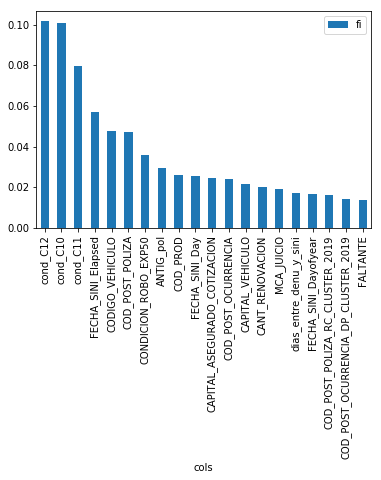

In [90]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [86]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 121 of 152


In [53]:
to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep

['es_gte_5',
 'cond_C10',
 'total_condicion',
 'cond_C11',
 'preg_32',
 'OCUPACION_ASEG',
 'cond_32',
 'METRO',
 'preg_33',
 'FALTANTE',
 'cond_C12',
 'DESCRIPCION_TIPO',
 'preg_34',
 'SEXO',
 'ESTAD_VEH_ASEG',
 'ESTADO_CIVIL',
 'CAPITAL_VEHICULO',
 'TIPO_SINIESTRO',
 'COD_POST_POLIZA',
 'SEGMENTO',
 'COD_POST_OCURRENCIA',
 'TIPO',
 'CODIGO_VEHICULO',
 'CONV_COMISIONARIO',
 'CAPITAL_ASEGURADO_COTIZACION',
 'CAPITAL_ACCESORIOS',
 'COD_PROD']

In [55]:
# best model
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 10},
           criterion='gini', max_depth=10, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=15,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [56]:
X_train_red = X_train[to_keep].copy()

In [57]:
print(len(X_train_red.columns))

33


### Training again with less features

In [58]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 10},
           criterion='gini', max_depth=10, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=15,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [59]:
y_val_pred = rf.predict(X_opt[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_opt, y_val_pred), roc_auc_score(y_opt, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4878048780487805, 0.8169460268770085)

In [60]:
confusion_matrix(y_opt, y_val_pred)

array([[7195,  629],
       [ 148,  370]])

In [61]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
0,es_gte_5,0.314610
1,cond_C10,0.187029
2,total_condicion,0.124276
5,OCUPACION_ASEG,0.025247
3,cond_C11,0.024490
4,preg_32,0.022295
8,preg_33,0.019963
9,FALTANTE,0.019271
7,METRO,0.016864
11,COD_POST_POLIZA_RC_CLUSTER_2019,0.015746


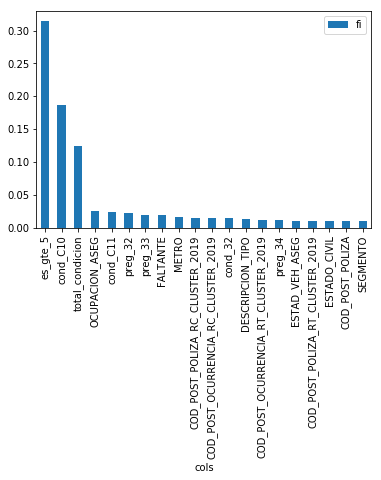

In [62]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# final model

In [ ]:
# reset_rf_samples()

## full features final model

In [39]:
rf_full = copy(best_model.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [40]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.746, 0.738


In [41]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[118, 145],
       [ 39, 270]])

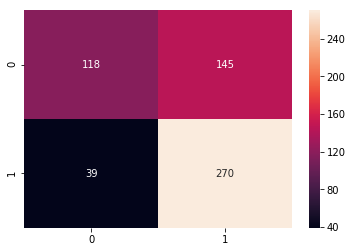

In [42]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [63]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 10},
           criterion='gini', max_depth=10, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=15,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [64]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.469, 0.893


In [65]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4500,  363],
       [  76,  194]])

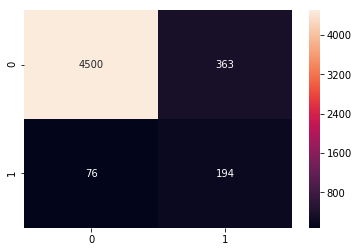

In [66]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [59]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.470873786407767,0.8222450704868967)


In [60]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[4503,  360],
       [  76,  194]])

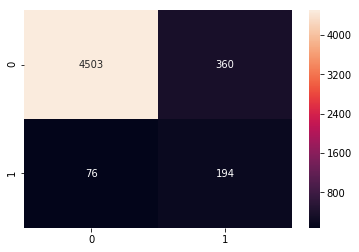

In [61]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [51]:
path_to_save = "../../src/models/1.1 - df_train 01-18to12-18/"
model_file = os.path.join(path_to_save, f"{model_id}(Model) - Model Optimization {metric} - class_weight {(rf_full.class_weight[0], rf_full.class_weight[1])} - time sorted - valid score ({metric_results}).pickle")

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [52]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [53]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['cond_C10', 'TIPO_EXPED', 'preg_15', 'es_gte_5', 'preg_31', 'preg_33', 'cond_32', 'preg_32', 'cond_C11', 'cond_C12', 'cond_C2', 'METRO', 'SEXO_TERC', 'OCUPACION_ASEG', 'FALTANTE', 'preg_34', 'cond_C5']


In [54]:
path_to_save = "../../src/features/1.1 - df_train 01-18to12-18/"
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - features: {len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [81]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [113]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [114]:
df_test = df_test[df_test["TIPO_EXPED"] == 6]

In [59]:
# Loding the model

def load_model(file_name):
    """Load the dump model."""
    folder = "models"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    model_file = os.path.join(path_to_load, file_name)

    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(file_name):
    """Load the array of columns use in the dump model."""
    folder = "features"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    columns_file = os.path.join(path_to_load, file_name)

    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [47]:
model_name = "1.1.b.2.f(Model) - Model Optimization recall - class_weight (1, 18) - time sorted - valid score (0.403, 0.972).pickle"
columns_name = "1.1.b.2.f (COLUMNS) - features: 17.pickle"
m = load_model(model_name)
columns = load_columns(columns_name)

In [115]:
X_test = df_test[X_train.columns]
y_test = df_test["EXISTE_FRAUDE"]

In [116]:
X_test = X_test

In [117]:
X_test = X_test.astype(float)
X_test.head()

,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C17,cond_C18,cond_C19,cond_C2,cond_C20,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,total_condicion,es_gte_5,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,preg_10,preg_11,preg_12,preg_15,preg_16,preg_18,preg_19,preg_22,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37,CATASTROFICO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_POST_TERC,COD_RAMO_sini,COD_RIES_sini,CONDICION_ROBO_EXP50,DANOS_MATERIALES,DESCRIPCION_TIPO,ESTADO_CIVIL,ESTADO_CIVIL_TERC,ESTAD_VEH_ASEG,FALTANTE,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,OCUPACION_ASEG,SEXO,SEXO_TERC,TELEFONO_TERC,TIPO,TIPO_EXPED,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,dist_fformal_fsini,dist_fformal_fdenu,existe_FECHA_FORMAL,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,COD_EST_CIVIL,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed,cant_pol,cant_sini_1y,COD_POST_POLIZA_DP_CLUSTER_2019,COD_POST_POLIZA_RT_CLUSTER_2019,COD_POST_POLIZA_RC_CLUSTER_2019,COD_POST_OCURRENCIA_DP_CLUSTER_2019,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_OCURRENCIA_RC_CLUSTER_2019,COD_POST_TERC_DP_CLUSTER_2019,COD_POST_TERC_RT_CLUSTER_2019,COD_POST_TERC_RC_CLUSTER_2019
11,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,270.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,12415.0,209.0,5010.0,5010.0,-1.0,1.0,1.0,-1.0,0.0,3.0,6.0,-1.0,3.0,0.0,0.0,-1.0,1.0,0.0,5.0,1.0,-1.0,-1.0,3.0,6.0,-1.0,-1.0,5.0,1.0,0.0,-1.0,-1.0,0.0,16.0,8.0,778.0,1324.0,0.0,0.0,5010.0,2.0,8.0,7.0,107.0,-1.0,0.0,0.0,-1.0,1.0,21.0,0.0,4.0,0.0,455.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.554077e+09,0.0,0.0,19.0,3.0,18.0,19.0,3.0,18.0,-1.0,-1.0,-1.0
13,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,21763.0,209.0,1759.0,1759.0,-1.0,1.0,1.0,-1.0,0.0,3.0,6.0,-1.0,3.0,1.0,0.0,-1.0,1.0,1.0,28.0,1.0,-1.0,-1.0,3.0,6.0,-1.0,-1.0,5.0,1.0,0.0,-1.0,-1.0,0.0,21.0,8.0,317.0,424.0,5.0,5.0,6030.0,1.0,1.0,1.0,107.0,-1.0,0.0,0.0,-1.0,1.0,21.0,0.0,4.0,0.0,608.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.554077e+09,0.0,0.0,29.0,10.0,25.0,29.0,10.0,25.0,-1.0,-1.0,-1.0
23,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,0.0,0.0,3.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,293.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,2035.0,209.0,1754.0,1766.0,-1.0,1.0,1.0,-1.0,0.0,2.0,6.0,-1.0,3.0,0.0,0.0,-1.0,1.0,1.0,8.0,1.0,-1.0,-1.0,6.0,6.0,-1.0,-1.0,7.0,1.0,0.0,-1.0,-1.0,0.0,35.0,182.0,1

## Model in test

In [118]:
# using trained model
y_test_pred_prob = best_model.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.425, 0.896


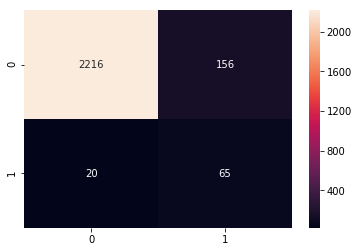

In [119]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador in test

In [120]:
y_tronador = X_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.444, 0.842


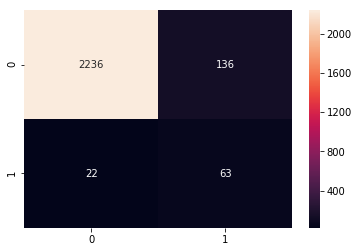

In [121]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")